In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, \
                            homogeneity_score, completeness_score, v_measure_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, SpectralClustering, AgglomerativeClustering

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

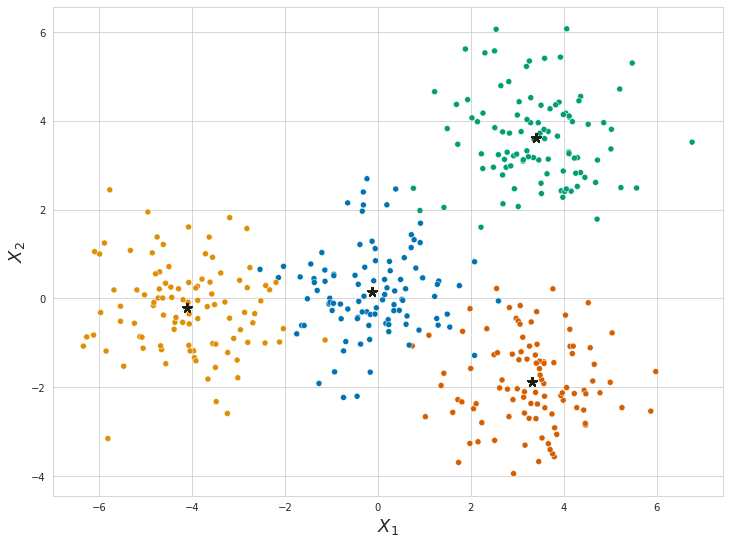

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        dists = []
        for centroid in self.centroids:
            dists.append(self._calculate_distance(X, centroid))
        dists = np.concatenate(dists, axis=1)
        cluster_labels = np.argmin(dists, axis=1)
        
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        return np.linalg.norm(X - centroid, axis = 1).reshape(-1, 1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

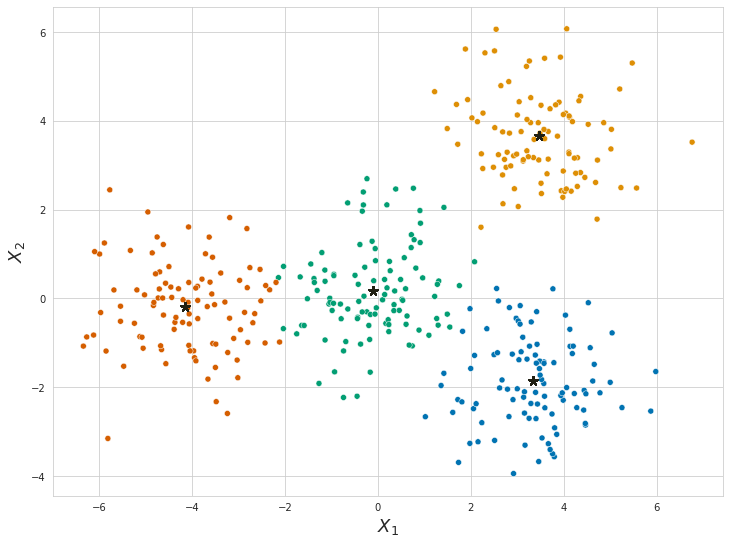

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [7]:
my_kmeans = MyKMeans(n_clusters = 4, init="sample", max_iter=10, visualize=True)
my_kmeans.fit(X)

In [8]:
preds = my_kmeans.predict(X)

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, preds)

array([[ 2,  0, 97,  1],
       [ 0,  0,  2, 98],
       [ 0, 97,  3,  0],
       [98,  0,  2,  0]])

In [10]:
adjusted_mutual_info_score(true_labels, preds)

0.9117474366398978

**Результат:**

* Для обоих типов инициализации центроидов, $-$ *sample* и *random* $-$ кластеры сходились одинаково быстро. Уже к 10-ой итерации центры были найдены довольно хорошо, что видно из картинки (визуализации);
* Судя по confusion_matrix абсолютное большинство точек предсказано верно (большие числа, ожидаемо, стоят не на диагонали, так как алгоритм не знает ничего об истинных метках).

$~$

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [11]:
data = load_digits()
X, y = data.data, data.target

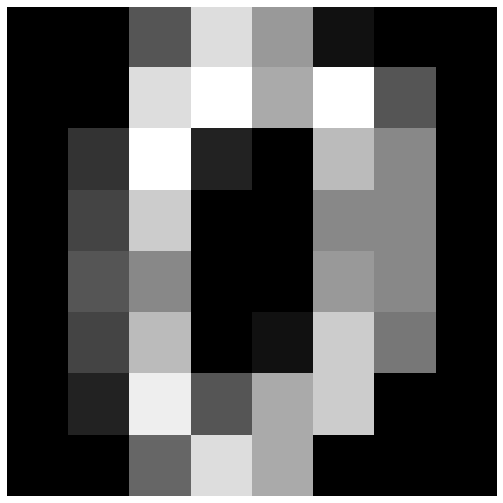

In [12]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`). Укажите для каждого алгоритма число кластеров равное количеству классов в `y`.

##### YOUR TURN TO CODE

In [13]:
def algorithm_selection(X, y,  distances, algorithms, metrics, n_clusters = len(np.unique(y))):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithms: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """
    data_row = []
    for alg in algorithms:
        for dist in distances:
            # для каждого значения из algorithm и distances
            # создаём модель
            model = AgglomerativeClustering(n_clusters = n_clusters,
                                            linkage = alg,
                                            affinity = dist)
            # обучаем модель
            model.fit(X)
            
            # делаем предсказания (вернее достаём, т.к. они уже есть)
            preds = model.labels_
            
            # смотрим на метрики
            # 1 -- метрики, не использующие разметку
            chs = calinski_harabasz_score(X, preds)
            sil = silhouette_score(X, preds, metric = 'euclidean')
            # 2 -- метрики, использующие разметку
            metrics_list = []
            if metrics:
                for metric in metrics.values():
                    metrics_list.append(metric(y, preds))
            
            # пишем всё в датафрэйм
            data_row.append(['AgglomerativeClustering', alg, dist, chs, sil, *metrics_list])
    
    
    if metrics:
        compare_dataframe = pd.DataFrame(data_row, columns = ['Model', 
                                                              'linkage', 
                                                              'distance',
                                                              'calinski_harabasz index',
                                                              'silhouette', 
                                                              *list(metrics.keys())
                                                             ])
    else:
        compare_dataframe = pd.DataFrame(data_row, columns = ['Model', 
                                                              'linkage', 
                                                              'distance',
                                                              'calinski_harabasz index',
                                                              'silhouette', 
                                                             ])
    
    return compare_dataframe

In [14]:
# посмотрим на силуэт для реальных y_values

silhouette_score(X, y, metric = 'cosine')


# если уж он для реальных такой небольшой...

0.26654416864958164

In [15]:
algorithms = ['average', 'single', 'complete']
distances = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2']
metrics = {
    'AMI': adjusted_mutual_info_score, 
    'ARI': adjusted_rand_score, 
    'homogeneity': homogeneity_score, 
    'completeness': completeness_score, 
    'v_measure': v_measure_score
}

In [16]:
algorithm_selection(X, y, distances, algorithms, metrics)

Model   linkage   distance  calinski_harabasz index  \
0   AgglomerativeClustering   average  euclidean               122.110600   
1   AgglomerativeClustering   average  manhattan                89.001474   
2   AgglomerativeClustering   average     cosine               109.889969   
3   AgglomerativeClustering   average         l1                89.001474   
4   AgglomerativeClustering   average         l2               122.110600   
5   AgglomerativeClustering    single  euclidean                 1.245737   
6   AgglomerativeClustering    single  manhattan                 0.952424   
7   AgglomerativeClustering    single     cosine                 1.094596   
8   AgglomerativeClustering    single         l1                 0.952424   
9   AgglomerativeClustering    single         l2                 1.245737   
10  AgglomerativeClustering  complete  euclidean               117.413505   
11  AgglomerativeClustering  complete  manhattan               139.529522   
12  AgglomerativeClustering  complete     cosine               103.307616   
13  AgglomerativeClustering  complete         l1               139.529522   
14  AgglomerativeClustering  complete         l2               117.413505   

    silhouette       AMI       ARI  homogeneity  completeness  v_measure  
0     0.146625  0.710310  0.514226     0.655393      0.782342   0.713263  
1     0.089217  0.652432  0.437400     0.566751      0.778942   0.656117  
2     0.129526  0.716911  0.535826     0.648268      0.808762   0.719676  
3     0.089217  0.652432  0.437400     0.566751      0.778942   0.656117  
4     0.146625  0.710310  0.514226     0.655393      0.782342   0.713263  
5    -0.133621  0.000084  0.000043     0.005056      0.273755   0.009929  
6    -0.166627  0.000175  0.000089     0.005102      0.276237   0.010019  
7    -0.158250  0.000071  0.000036     0.005050      0.273389   0.009916  
8    -0.166627  0.000175  0.000089     0.005102      0.276237   0.010019  
9    -0.133621  0.000084  0.000043     0.005056      0.273755   0.009929  
10    0.119271  0.609197  0.428689     0.590549      0.637772   0.613253  
11    0.140183  0.662191  0.474712     0.646372      0.686109   0.665648  
12    0.088021  0.547273  0.353826     0.528727      0.577415   0.551999  
13    0.140183  0.662191  0.474712     0.646372      0.686109   0.665648  
14    0.119271  0.609197  0.428689     0.590549      0.637772   0.613253

**Выводы:**

* single-linkage алгоритм сильно просел
* лучшие результаты показал алгоритм с `linkage`='average', `distance`='cosine' / 'euclidean'

$~$

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [17]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [18]:
# убираем NA значения (они были)

if any(fc_data.isna()):
    fc_data = fc_data.dropna()
    print("All NA's gone")
else:
    print("No NA's found")

All NA's gone


In [19]:
fc_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FSC-A   10000 non-null  float64
 1   SSC-A   10000 non-null  float64
 2   HLA-DR  10000 non-null  float64
 3   CD3     10000 non-null  float64
 4   CD45    10000 non-null  float64
 5   CD14    10000 non-null  float64
 6   CD56    10000 non-null  float64
 7   CD19    10000 non-null  float64
 8   CD11c   10000 non-null  float64
dtypes: float64(9)
memory usage: 781.2 KB


In [20]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

In [21]:
# уберём точку-выброс (её видно на графике sns.pairplot, и в data.describe как слишком большое max значение для FSC-A)

fc_data = fc_data.drop(fc_data.loc[fc_data['FSC-A'] == 42.954485].index, axis = 0)

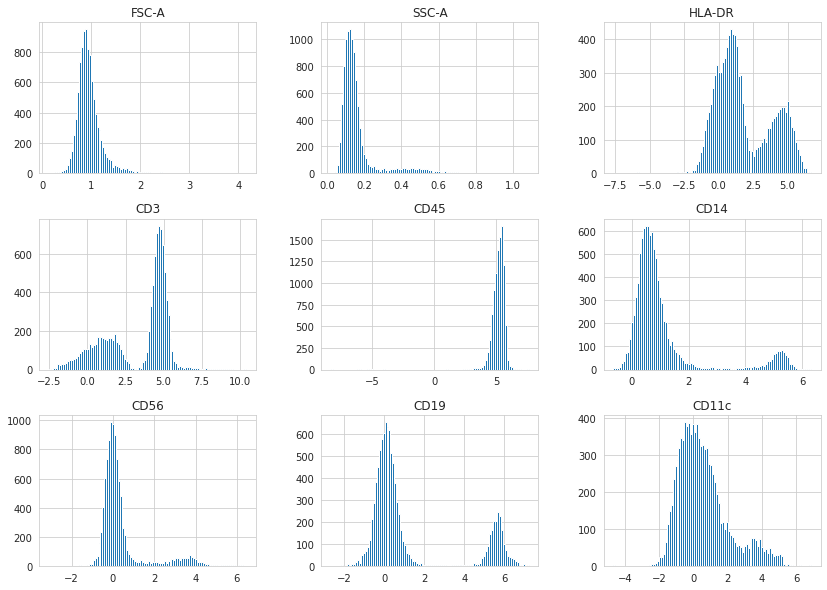

In [22]:
# посмотрим на гистограммы

fc_data.hist(column = fc_data.columns, figsize = (14, 10), bins = 100)
None

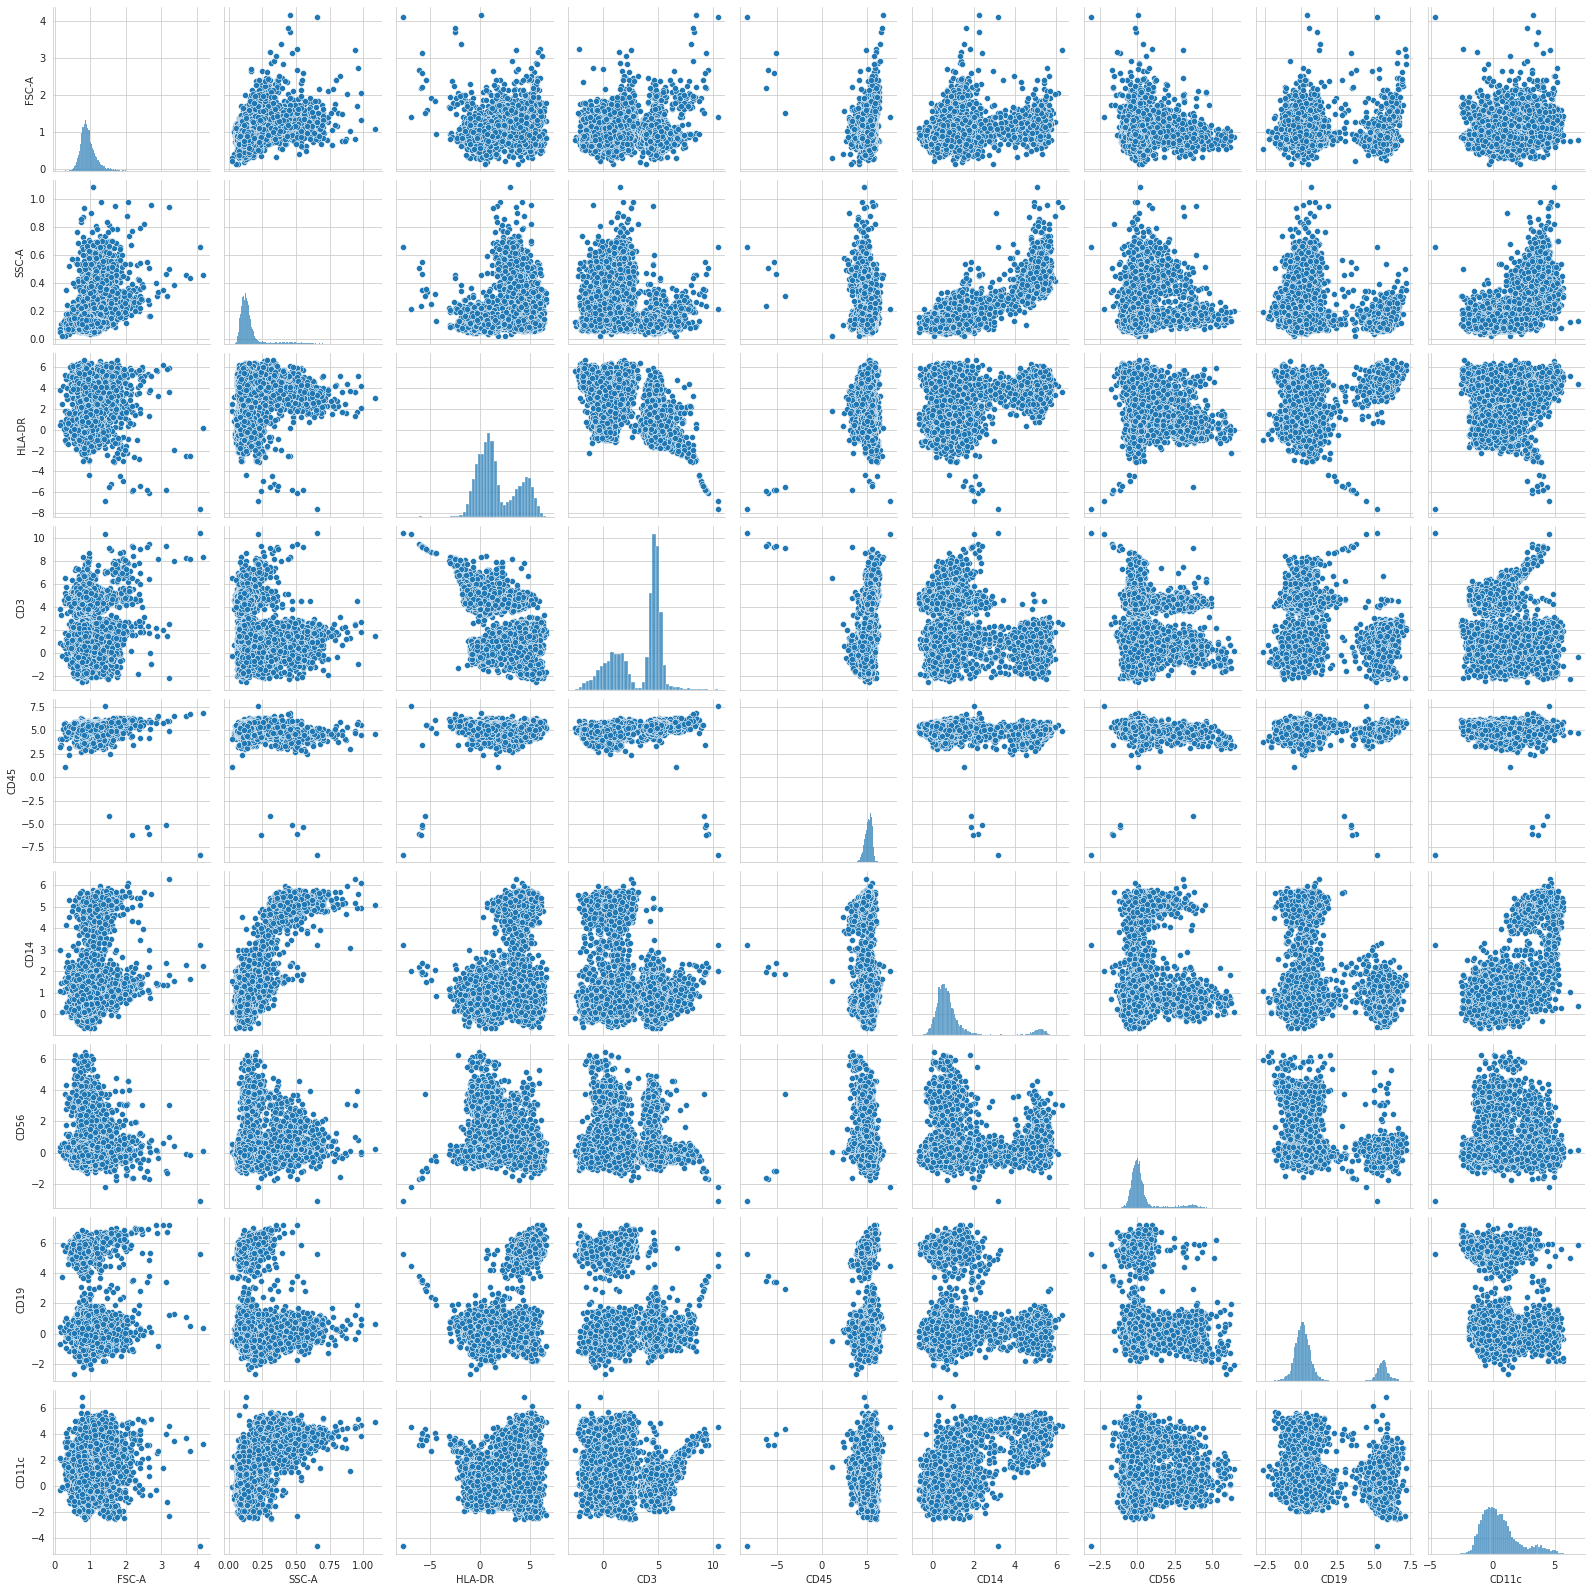

In [23]:
# диаграмма рассеяния
# проверяем группировку данных

sns.pairplot(fc_data)
plt.show()

**Мини-выводы:**
* Столбцы FSC-A, SSC-A косвенным образом свидетельствуют о размере клеток. Они распределены нормально, что очень хорошо;
* Остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Можно сразу видеть несколько чётко выраженных пиков. То есть мы имеем как минимум 2 типа клеток;
* Очевидную точку-выброс убрали.

**Итого:** 9999 сэмплов (клеток), 7 признаков (без учёта первых двух столбцов).

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [24]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

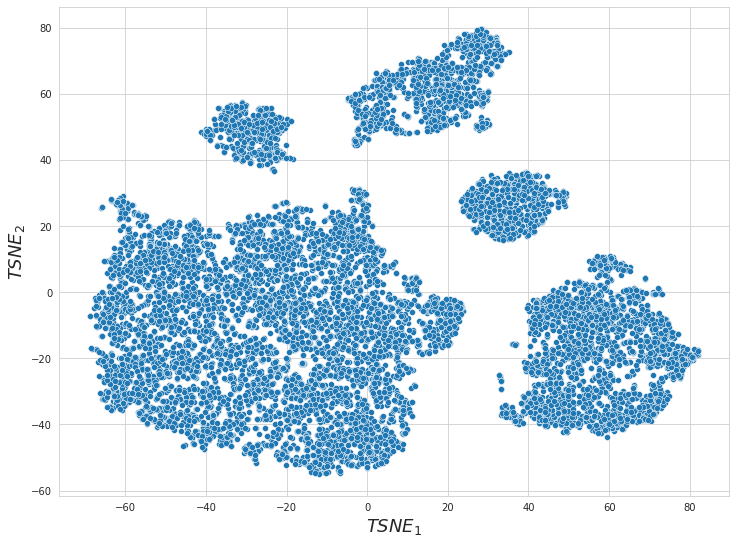

In [25]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

##### 3.2.0 Стандартизация

In [51]:
# СТАНДАРТИЗАЦИЯ:
from sklearn.preprocessing import StandardScaler

pca = StandardScaler()
X_standartized = pca.fit_transform(fc_data)

In [53]:
X = X_standartized
# X = fc_data

##### 3.2.1 KMeans

In [54]:
# рассчитываем score силуэта для разного числа соседей (от 1 до 14)

silhouette_values = []

for i in range(2,15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    silhouette_values.append(silhouette_score(X, kmeans.labels_))

Text(0, 0.5, 'Silhouette score')

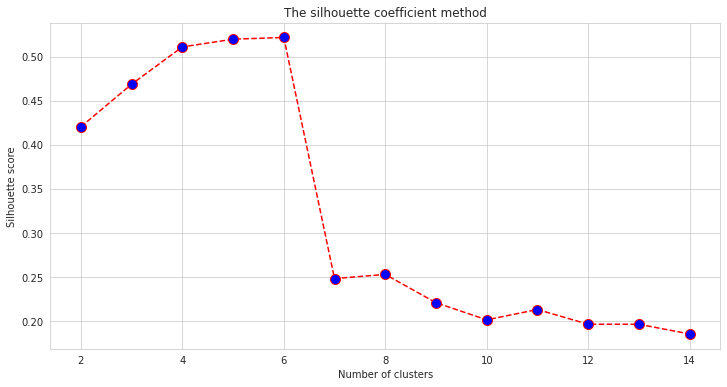

In [55]:
# выводим значения score силуэта на график

plt.figure(figsize=(12, 6))
plt.plot(range(2, 15), silhouette_values, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('The silhouette coefficient method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

Количество кластеров можно предсказывать методом локтя, либо по пику метрики "силуэт". Если выбирать количество кластеров по силуэту, то надо было бы остановиться на 6-и. Но мы из TSNE-визуализации видим, что должно быть **5 кластеров**, поэтому будем опираться на это число.

In [56]:
# для каждого алгоритма будем замерять время

import time

In [57]:
KMeans_start = time.process_time()

KMeans_model = KMeans(n_clusters=5)
KMeans_model.fit(X)

KMeans_time = time.process_time()-KMeans_start

In [58]:
for i in range(0, 5):
    print('Для кластера №', i, 'число элементов внутри =', len(kmeans.labels_[kmeans.labels_ == i]))

Для кластера № 0 число элементов внутри = 1689
Для кластера № 1 число элементов внутри = 384
Для кластера № 2 число элементов внутри = 439
Для кластера № 3 число элементов внутри = 801
Для кластера № 4 число элементов внутри = 656


$~$

Все основные показатели алгоритма будем заносить в датафрэйм.

In [59]:
KMeans_info = {
        'Время': KMeans_time,
        'Calinski-Harabasz Index': calinski_harabasz_score(X, KMeans_model.labels_),
        'Silhouette': silhouette_score(X, KMeans_model.labels_),
    }

In [61]:
results = pd.DataFrame(data=KMeans_info, 
                       columns=['Время', 'Calinski-Harabasz Index', 'Silhouette'],
                       index=['K-means'])

results

Время  Calinski-Harabasz Index  Silhouette
K-means  4.405019              5263.744242    0.519805

$~$

Также для каждого алгоритма отрисуем график.

Text(0, 0.5, '$TSNE_2$')

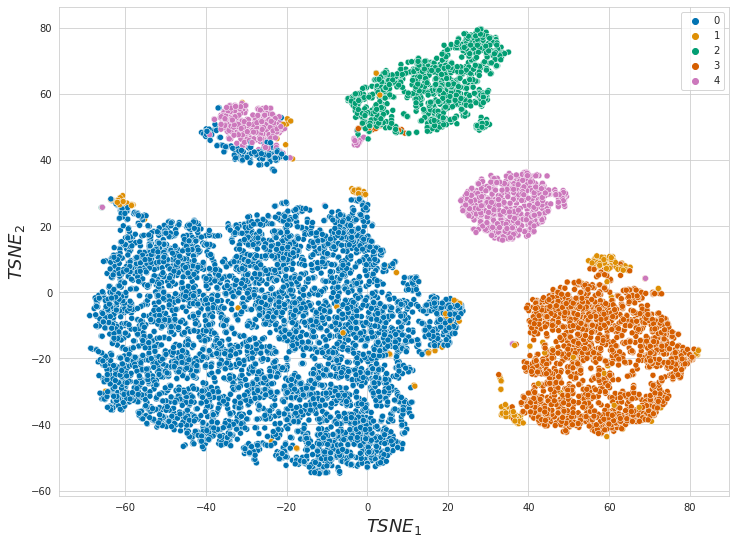

In [62]:
sns.scatterplot(x=tsne_res[:, 0],
                y=tsne_res[:, 1],
                hue=KMeans_model.labels_,
                palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

**Результат:** большие кластеры определились неплохо, но вот кластер $№1$ раскидало как-то рандомно.

##### 3.2.2 DBSCAN - Density-based spatial clustering of applications with noise

Плостностный алгоритм. Хорошо работает когда кластеры обладают сложной формой (например для случаев кластер-в-кластере), главное чтобы они были плотные и отдалены друг от друга. Сам определяет оптимальное число кастеров.

Всем точкам присваивается определённый статус:

* core $-$ если есть min_samples точек в радиусе eps;
* border $-$ non-core точка, но находится в eps-радиусе от core точки;
* outlier $-$ точка-выброс (шум), её label=-1. Параметр min_samples контролирует устойчивость к шумам.

Сложность классического DBSCAN $O(n)$, но реализация в sklearn перебирает ещё и соседей точки (d), что увеличивает сложность до $O(nd)$. Хотя есть возможности снизить сложность, в частности заранее отдельно обрабатывать разреженные области, и использовать предобработку при прогоне DBSCAN. Алгоритм может давать разный результат, если данные подаются в разном порядке. Также результат очень зависит от выбора eps (есть алгоритмы для оптимального выбора eps по методу колена (или локтя) [[1](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc)][[2](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf)]).

Для начала необходимо выбрать eps. Воспользуемся отмеченным выше методом локтя.


In [63]:
# рассчитываем расстояние до ближайшего соседа

from sklearn.neighbors import NearestNeighbors


neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]  # берём 2ую колонку, ибо в 1-ой расстояние до самого себя (0)

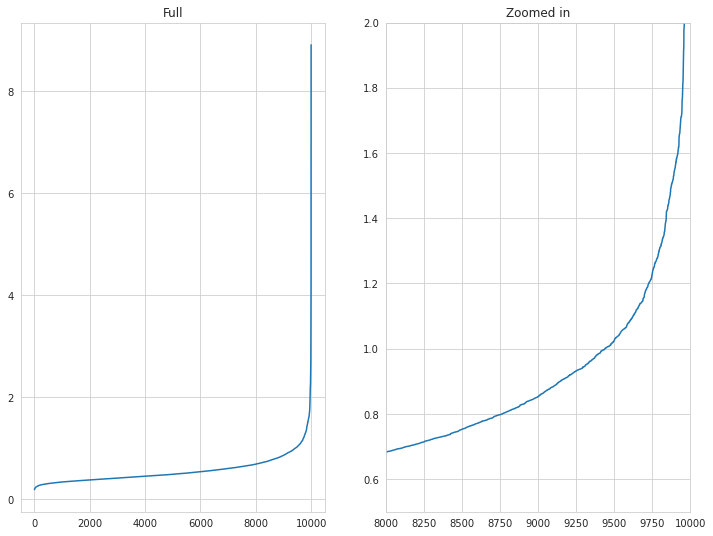

In [64]:
# строим график
# выбираем eps из области перегиба ([0.5; 1.4]), но это для стандартизованных данных

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(distances)
ax1.set_title('Full')

ax2.set_xlim(8000, 10000)
ax2.set_ylim(.5, 2)
ax2.set_title('Zoomed in')
ax2.plot(distances)

Остановимся на `eps = 1.0`. Теперь выберем наилучший min_samples:

In [65]:
DBSCAN_metrics = []

for min_samples in range(5,20):
    DBSCAN_test_model = DBSCAN(eps=1.0, min_samples=min_samples)
    DBSCAN_test_model.fit(X)
    DBSCAN_metrics.append(({
        'Calinski-Harabasz Index': calinski_harabasz_score(X, DBSCAN_test_model.labels_),
        'Silhouette': silhouette_score(X, DBSCAN_test_model.labels_),
        'Число кластеров': len(set(DBSCAN_test_model.labels_))-1  # вычитаем 1 так как одна из меток отвечает за шум
    }))
    
    
pd.DataFrame(data=DBSCAN_metrics, index=list(range(5,20)))

Calinski-Harabasz Index  Silhouette  Число кластеров
5               1175.943474    0.368956               13
6               1625.611218    0.409349                9
7               1790.770340    0.420072                8
8               1430.632544    0.423200               10
9               1995.275379    0.423832                7
10              1977.407656    0.422601                7
11              1946.692325    0.419771                7
12              1934.429471    0.418221                7
13              1674.859693    0.413449                8
14              2203.832738    0.416733                6
15              2183.566682    0.415339                6
16              2582.917662    0.433937                5
17              2557.957285    0.431788                5
18              2543.847602    0.430559                5
19              2523.858694    0.428779                5

`min_samples = 16` показывает лучший результат и даёт нужное число кластеров (5 штук). Остановимся на нём

In [66]:
DBSCAN_start = time.process_time() # засекаем время

DBSCAN_model = DBSCAN(eps=1.0, min_samples=16)
DBSCAN_model.fit(X)

DBSCAN_time = time.process_time() - DBSCAN_start

In [67]:
DBSCAN_info = {
        'Время': DBSCAN_time,
        'Calinski-Harabasz Index': calinski_harabasz_score(X, DBSCAN_model.labels_),
        'Silhouette': silhouette_score(X, DBSCAN_model.labels_),
    }

In [68]:
# дописываем в нашу табличку результаты для DBSCAN

results = results.append(pd.DataFrame(data=DBSCAN_info, 
                                      columns=['Время', 'Calinski-Harabasz Index', 'Silhouette'],
                                      index=['DBSCAN']))

results

Время  Calinski-Harabasz Index  Silhouette
K-means  4.405019              5263.744242    0.519805
DBSCAN   1.571150              2582.917662    0.433937

<br>
Баланс классов:

In [69]:
for i in range(0, 5):
    print('Для кластера №', i, 'число элементов внутри =', len(DBSCAN_model.labels_[DBSCAN_model.labels_ == i]))

Для кластера № 0 число элементов внутри = 1718
Для кластера № 1 число элементов внутри = 5981
Для кластера № 2 число элементов внутри = 547
Для кластера № 3 число элементов внутри = 503
Для кластера № 4 число элементов внутри = 44


$~$

Покрасим точки:

Text(0, 0.5, '$TSNE_2$')

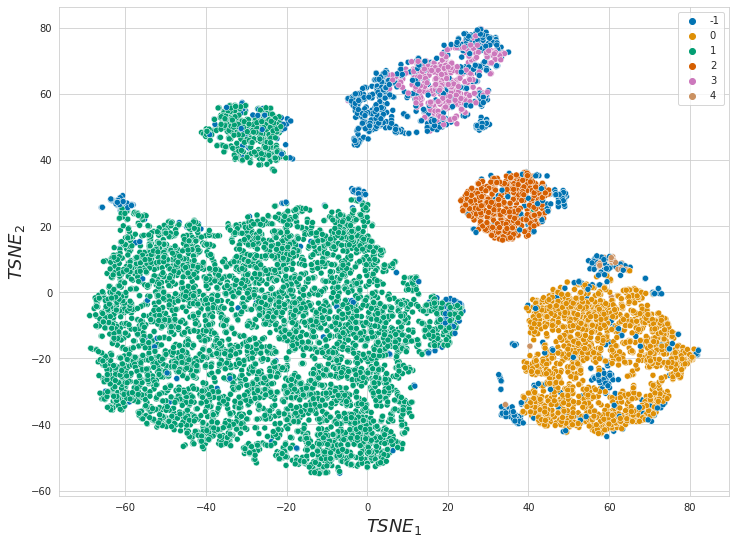

In [70]:
sns.scatterplot(x=tsne_res[:, 0],
                y=tsne_res[:, 1],
                hue=DBSCAN_model.labels_,
                palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

**Результат:** неплохо смог определить 4 кластера, хотя довольно большой кусок $3$-его кластера пометил как шум (кластер $№(-1)$ отвечает за шумовые данные). А вот с кластером $№4$ он облажался, засунув туда всего 44 точки.

##### 3.2.3 Метод распространения близости (Affinity Propagation)

Алгоритм является матричным (similarity, responsibility, availability, criterion matix). Способен сам выбирать оптимальное количество кластеров. Организация кластеров основана на формировании матрицы "похожести" и выборе "точки-лидера" (exemplar - точка, максимально похожая на другие). Точки, имеющие (после всех итераций) одинаковую "точку-лидера", относятся к одному кластеру. Таким образом, нет необходимости делать гиперсферы как в KMeans, и можно кластеризовать более сложные данные.

Из недостатков у алгоритма сложность ($O(N^2T)$, $N$- число образцов, $T$- число итераций до сходимости) и использование памяти ($O(N^2)$, но может быть снижено). Так что лучше использовать для датасетов среднего размера.

In [71]:
AP_start = time.process_time() # засекаем время

AP_model = AffinityPropagation(random_state=42)
AP_model.fit(X)

AP_time = time.process_time() - AP_start

In [72]:
AP_info = {
        'Время': AP_time,
        'Calinski-Harabasz Index': calinski_harabasz_score(X, AP_model.labels_),
        'Silhouette': silhouette_score(X, AP_model.labels_),
    }

print('Число кластеров = ', len(set(AP_model.labels_)))

Число кластеров =  179


In [73]:
# дописываем в нашу табличку результаты для Affinity Propagation

results = results.append(pd.DataFrame(data=AP_info, index=['Affinity Propagation']))

results

Время  Calinski-Harabasz Index  Silhouette
K-means                 4.405019              5263.744242    0.519805
DBSCAN                  1.571150              2582.917662    0.433937
Affinity Propagation  164.035406               620.874704    0.084648

**Результат:** нашёл 179 кластеров. Метрики так себе. Даже можно не рисовать.

<br>

##### 3.2.4 Спектральный метод (Spectral clustering)

Алгоритм формирует связный граф, который проецируется в пространство пониженной размерности, где и происходит кластеризация (удаление наиболее длинных рёбер\KMeans...). Требует задания числа кластеров.

Лучше использовать для средних датасетов и малого числа кластеров.

In [74]:
SC_start = time.process_time() # засекаем время

SC_model = SpectralClustering(n_clusters=5, )
SC_model.fit(X)

SC_time = time.process_time() - SC_start

In [75]:
SC_info = {
        'Время': SC_time,
        'Calinski-Harabasz Index': calinski_harabasz_score(X, SC_model.labels_),
        'Silhouette': silhouette_score(X, SC_model.labels_),
    }

In [76]:
# дописываем в нашу табличку результаты для спектрального метода

results = results.append(pd.DataFrame(data=SC_info, index=['Spectral Clustering']))

results

Время  Calinski-Harabasz Index  Silhouette
K-means                 4.405019              5263.744242    0.519805
DBSCAN                  1.571150              2582.917662    0.433937
Affinity Propagation  164.035406               620.874704    0.084648
Spectral Clustering   156.632654              1213.884214    0.485445

<br>
Баланс классов:

In [77]:
for i in range(0, 5):
    print('Для кластера №', i, 'число элементов внутри =', len(SC_model.labels_[SC_model.labels_ == i]))

Для кластера № 0 число элементов внутри = 1078
Для кластера № 1 число элементов внутри = 5
Для кластера № 2 число элементов внутри = 4
Для кластера № 3 число элементов внутри = 1
Для кластера № 4 число элементов внутри = 8911


$~$

Покрасим точки:

Text(0, 0.5, '$TSNE_2$')

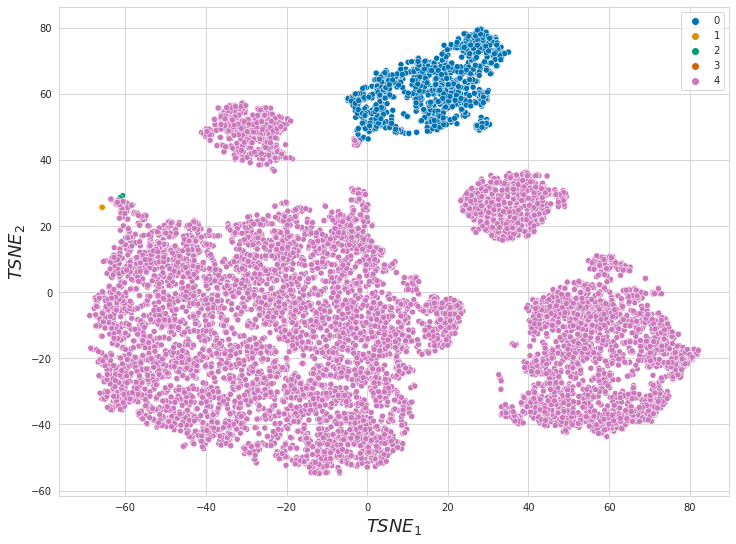

In [78]:
sns.scatterplot(x=tsne_res[:, 0],
                y=tsne_res[:, 1],
                hue=SC_model.labels_,
                palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

**Результат:** неплохо нашёл 2 класса. Возможно, если поиграться с гиперпараметрами, выйдет что-то более дельное.

##### 3.2.5 Agglomerative Clustering

При помощи функции из 2-го задания найдём лучшие гиперпараметры:

In [79]:
algorithm_selection(X = X, 
                    y = [],
                    n_clusters = 5,
                    distances = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2'], 
                    algorithms = ['average', 'single', 'complete'], 
                    metrics = [])

Model   linkage   distance  calinski_harabasz index  \
0   AgglomerativeClustering   average  euclidean               130.530862   
1   AgglomerativeClustering   average  manhattan               111.806825   
2   AgglomerativeClustering   average     cosine              4488.248237   
3   AgglomerativeClustering   average         l1               111.806825   
4   AgglomerativeClustering   average         l2               130.530862   
5   AgglomerativeClustering    single  euclidean                99.884418   
6   AgglomerativeClustering    single  manhattan                99.724413   
7   AgglomerativeClustering    single     cosine                 0.183635   
8   AgglomerativeClustering    single         l1                99.724413   
9   AgglomerativeClustering    single         l2                99.884418   
10  AgglomerativeClustering  complete  euclidean               393.926202   
11  AgglomerativeClustering  complete  manhattan              1639.302934   
12  AgglomerativeClustering  complete     cosine              1914.322824   
13  AgglomerativeClustering  complete         l1              1639.302934   
14  AgglomerativeClustering  complete         l2               393.926202   

    silhouette  
0     0.578083  
1     0.510467  
2     0.486464  
3     0.510467  
4     0.578083  
5     0.594477  
6     0.580860  
7    -0.370690  
8     0.580860  
9     0.594477  
10    0.341479  
11    0.370700  
12    0.119284  
13    0.370700  
14    0.341479

Лучшие параметры это `linkage = 'single'` и `distance = 'euclidean'`.

In [80]:
AC_start = time.process_time() # засекаем время

AC_model = AgglomerativeClustering(n_clusters = 5,
                                   linkage = 'single',
                                   affinity = 'euclidean')
AC_model.fit(X)

AC_time = time.process_time() - AC_start

In [81]:
AC_info = {
        'Время': AC_time,
        'Calinski-Harabasz Index': calinski_harabasz_score(X, AC_model.labels_),
        'Silhouette': silhouette_score(X, AC_model.labels_),
    }

In [82]:
# дописываем в нашу табличку результаты для аггломеративной кластеризации

results = results.append(pd.DataFrame(data=AC_info, index=['Agglomerative Clustering (single + euclidean)']))

results

Время  \
K-means                                          4.405019   
DBSCAN                                           1.571150   
Affinity Propagation                           164.035406   
Spectral Clustering                            156.632654   
Agglomerative Clustering (single + euclidean)    0.929971   

                                               Calinski-Harabasz Index  \
K-means                                                    5263.744242   
DBSCAN                                                     2582.917662   
Affinity Propagation                                        620.874704   
Spectral Clustering                                        1213.884214   
Agglomerative Clustering (single + euclidean)                99.884418   

                                               Silhouette  
K-means                                          0.519805  
DBSCAN                                           0.433937  
Affinity Propagation                             0.084648  
Spectral Clustering                              0.485445  
Agglomerative Clustering (single + euclidean)    0.594477

<br>
Баланс классов:

In [83]:
for i in range(0, 5):
    print('Для кластера №', i, 'число элементов внутри =', len(AC_model.labels_[AC_model.labels_ == i]))

Для кластера № 0 число элементов внутри = 9992
Для кластера № 1 число элементов внутри = 4
Для кластера № 2 число элементов внутри = 1
Для кластера № 3 число элементов внутри = 1
Для кластера № 4 число элементов внутри = 1


<br>

**Промежуточный результат:** Метрики просто супер, но он засунул всё в один класс! Поэтому попробуем взять лучшее не по силуэту, а по индексу Калински-Харабаса (`linkage = 'average'` и `distance = 'cosine'`.)

Этот индекс показывает насколько хорошо разошлись кластеры (на основе разницы дисперсий внутри кластера и межкластерной дисперсии). 

In [84]:
AC_start = time.process_time() # засекаем время

AC_model = AgglomerativeClustering(n_clusters = 5,
                                   linkage = 'average',
                                   affinity = 'cosine')
AC_model.fit(X)

AC_time = time.process_time() - AC_start

In [85]:
for i in range(0, 5):
    print('Для кластера №', i, 'число элементов внутри =', len(AC_model.labels_[AC_model.labels_ == i]))

Для кластера № 0 число элементов внутри = 5731
Для кластера № 1 число элементов внутри = 43
Для кластера № 2 число элементов внутри = 1089
Для кластера № 3 число элементов внутри = 1098
Для кластера № 4 число элементов внутри = 2038


In [86]:
AC_info = {
        'Время': AC_time,
        'Calinski-Harabasz Index': calinski_harabasz_score(X, AC_model.labels_),
        'Silhouette': silhouette_score(X, AC_model.labels_),
    }

results = results.append(pd.DataFrame(data=AC_info, index=['Agglomerative Clustering (average+cosine)']))
results

Время  \
K-means                                          4.405019   
DBSCAN                                           1.571150   
Affinity Propagation                           164.035406   
Spectral Clustering                            156.632654   
Agglomerative Clustering (single + euclidean)    0.929971   
Agglomerative Clustering (average+cosine)        3.890006   

                                               Calinski-Harabasz Index  \
K-means                                                    5263.744242   
DBSCAN                                                     2582.917662   
Affinity Propagation                                        620.874704   
Spectral Clustering                                        1213.884214   
Agglomerative Clustering (single + euclidean)                99.884418   
Agglomerative Clustering (average+cosine)                  4488.248237   

                                               Silhouette  
K-means                                          0.519805  
DBSCAN                                           0.433937  
Affinity Propagation                             0.084648  
Spectral Clustering                              0.485445  
Agglomerative Clustering (single + euclidean)    0.594477  
Agglomerative Clustering (average+cosine)        0.486464

$~$

Покрасим точки:

Text(0, 0.5, '$TSNE_2$')

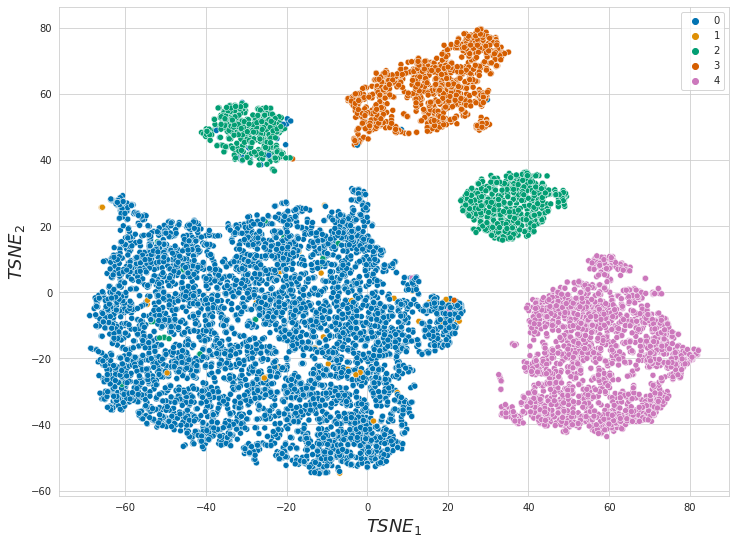

In [87]:
sns.scatterplot(x=tsne_res[:, 0],
                y=tsne_res[:, 1],
                hue=AC_model.labels_,
                palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

**Результат:** Несмотря на то, что мы хотели 5 кластеров, это, пожалуй, лучший результат среди всех алгоритмов. Очень чётко выделились 4 кластера.

**Итоговая таблица работы алгоритмов:**

In [88]:
results

Время  \
K-means                                          4.405019   
DBSCAN                                           1.571150   
Affinity Propagation                           164.035406   
Spectral Clustering                            156.632654   
Agglomerative Clustering (single + euclidean)    0.929971   
Agglomerative Clustering (average+cosine)        3.890006   

                                               Calinski-Harabasz Index  \
K-means                                                    5263.744242   
DBSCAN                                                     2582.917662   
Affinity Propagation                                        620.874704   
Spectral Clustering                                        1213.884214   
Agglomerative Clustering (single + euclidean)                99.884418   
Agglomerative Clustering (average+cosine)                  4488.248237   

                                               Silhouette  
K-means                                          0.519805  
DBSCAN                                           0.433937  
Affinity Propagation                             0.084648  
Spectral Clustering                              0.485445  
Agglomerative Clustering (single + euclidean)    0.594477  
Agglomerative Clustering (average+cosine)        0.486464

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

**Ответ:** да, удалось. 4 кластера довольно чётко выделились в алгоритмах KMeans, DBSCAN, Agglomerative Clustering.

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

**Теперь, когда мы знаем реальное число кластеров, обучим лучшую модель на нужном их количестве:**

In [89]:
best_model = AgglomerativeClustering(n_clusters = 4,
                                     linkage = 'average',
                                     affinity = 'cosine')
best_model.fit(X)

AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=4)

Text(0, 0.5, '$TSNE_2$')

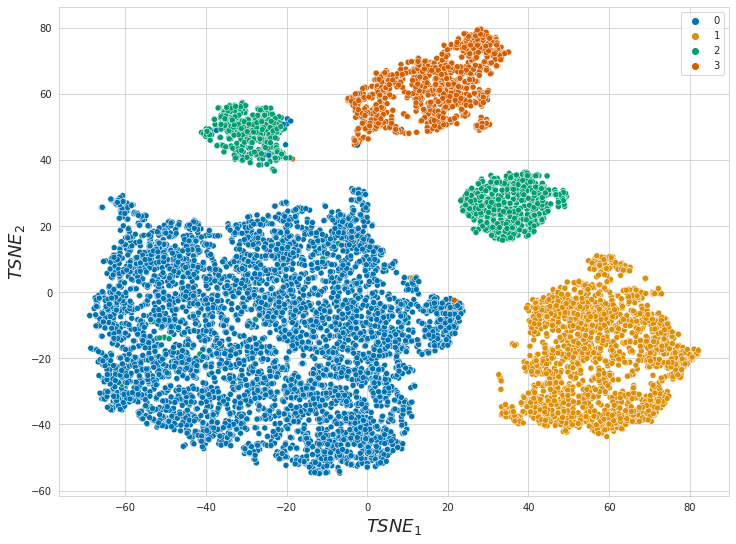

In [90]:
sns.scatterplot(x=tsne_res[:, 0],
                y=tsne_res[:, 1],
                hue=best_model.labels_,
                palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

**Нарисуем все это безобразие:**

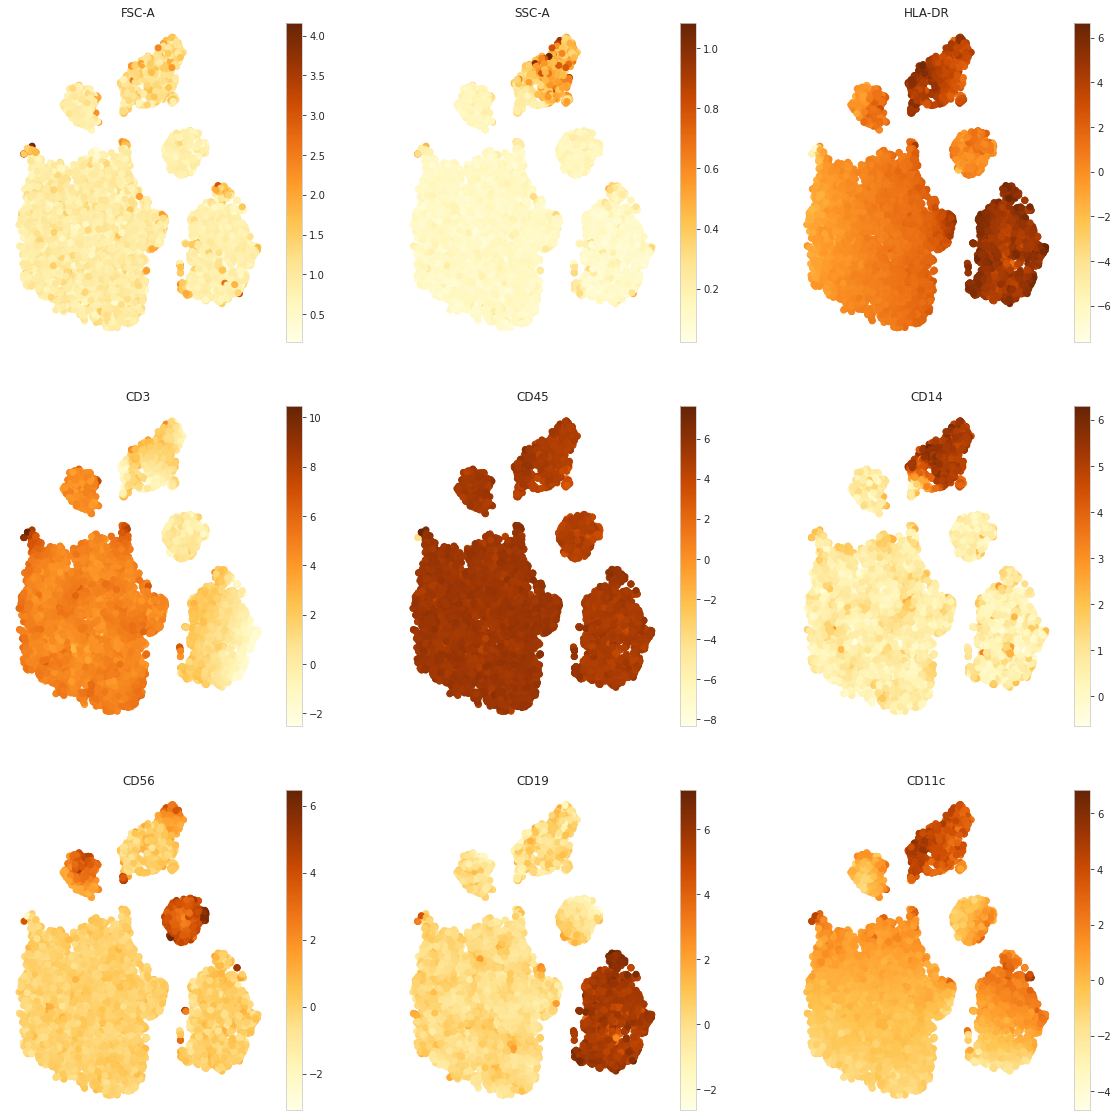

In [91]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

**Соотнесём кластеры и типы клеток:**

Маркеры, экспрессирующиеся клеточными типами, и их соответствие кластерам:

* B_cells $-$ CD19 $-$ правый нижний кластер ($№1$)
* T_cells $-$ CD3 $-$ большой кластер слева снизу ($№0$)
* Monocytes $-$ C14 $-$ верхний кластер ($№3$)
* Other cells $-$ всё остальное ($№2$)

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [92]:
cell_type_cluster_map = {0: "T_cells", 
                         1: "B_cells", 
                         2: "Other cells", 
                         3: "Monocytes"}

In [94]:
labeled_fc_data = fc_data.assign(Population=best_model.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [96]:
labeled_fc_data.Population.value_counts()

T_cells        5774
B_cells        2038
Monocytes      1098
Other cells    1089
Name: Population, dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [100]:
labeled_fc_data.to_csv('data/flow_c_data_labels_predicted.csv')

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

**XGBoost**

In [118]:
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

Наверное один из лучших классификаторов $-$ алгоритм градиентного бустинга, основан на дереве поиска решений. Градиентный спуск позволяет минимизировать ошибку. Строится дерево с максимальным числом слоёв. Неэффективные узлы отбрасываются. Реализована регуляризация, параллелизация. Алгоритм имеет приёмы для борьбы с пропусками данных.

Чтобы снизить время на создание сетки и перебор всех параметров можно использовать метод покоординатного спуска Гаусса. Определять параметры по одному в несколько циклов. Уменьшаем время, но рискуем не попасть в минимум.


In [ ]:
# гиперпараметры классификатора:

# booster -- тип модели (деревья\линейные)
# objective -- функция потерь для минимизации
# nthread -- число ядер для параллелизации
# learning rate -- "эта", определяет скорость обучения (размер шага)
# max_depth -- максимальная глубина дерева (6 по умолчанию)
# min_child_weight -- определяет минимальную сумму весов (позволяет отбрасывать "чахлые" листья)
# silent -- будет ли что-то выводиться
# subsample -- какая часть данных используется для построения дерева
# colsample_bytree -- та же max_features, число колонок (фичей), используемых для одного дерева
# n_estimators -- количество деревьев

In [111]:
# выделяем данные

X = labeled_fc_data.drop('Population', axis = 1)
y = labeled_fc_data.Population

In [119]:
# делим на трэин/тест

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [121]:
# обучаем классификатор

XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

[22:27:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [122]:
# делаем предсказания

y_pred = XGB_model.predict(X_test)

In [123]:
f1_score(y_test, y_pred, average='macro')

0.9972184975896305

Получили хороший score, так как алгоритмы, основанные на деревьях (а XGBoost именной такой) неплохо работают с несбалансированными классами благодаря иерархической структуре.

$~$

Финальный этап: учим классификатор на всех данных, чтобы он был готов предсказывать новые

In [124]:
XGB_model = XGBClassifier()
XGB_model.fit(X, y)

[22:30:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

$~$

Если делать ресэмпл для выравнивания баланса классов, то, на мой взгляд, логично:

* уменьшить число сэмплов у T_cells (с 5000 до где-нибудь ~1500);
* у Monocytes и Other cells повысить число сэмплов до 1500;
* для B_cells оставить число сэмплов (2000).

Хотя насколько правомерно копировать половину значений для upsample'а -- вопрос себе на подумать.

In [125]:
from sklearn.utils import resample

In [130]:
# down-sample для класса, где сэмплов слишком много

df_majority = labeled_fc_data[labeled_fc_data.Population=='T_cells']
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=1700,     # to match minority class
                                   random_state=42) # reproducible results

In [133]:
# up-sample для классов, где сэмплов маловато

df_minority_monocytes = labeled_fc_data[labeled_fc_data.Population=='Monocytes']
df_minority_others = labeled_fc_data[labeled_fc_data.Population=='Other cells']

df_minority_monocytes_upsampled = resample(df_minority_monocytes, 
                                           replace=True,     # sample with replacement
                                           n_samples=1700,    # to match majority class
                                           random_state=42) # reproducible results

df_minority_others_upsampled = resample(df_minority_others, 
                                        replace=True,     # sample with replacement
                                        n_samples=1700,    # to match majority class
                                        random_state=42) # reproducible results

In [134]:
# нормальный класс, который нас устраивает

df_ok_Bcells = labeled_fc_data[labeled_fc_data.Population=='B_cells']

In [136]:
# склеиваем всё обратно в датасет

fc_sample_balanced = pd.concat([df_majority_downsampled, 
                                df_minority_monocytes_upsampled,
                                df_minority_others_upsampled,
                                df_ok_Bcells])

fc_sample_balanced.Population.value_counts()

B_cells        2038
T_cells        1700
Monocytes      1700
Other cells    1700
Name: Population, dtype: int64

$~$

И дальше уже можно работать с чем-то таким.

In [137]:
# # данные
# X = fc_sample_balanced.drop('Population', axis = 1)
# y = fc_sample_balanced.Population

# # train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # обучаем классификатор
# XGB_model = XGBClassifier()
# XGB_model.fit(X_train, y_train)

# # предсказываем + смотрим метрику
# f1_score(y_test, XGB_model.predict(X_test), average='macro')

[22:53:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.997827847120332

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

$~$

Хочу побывать на маяке на острове Сухо. Туда хрен доберёшься: зимой надо преодолевать расстояние по льду (а с последними зимами это не всегда надёжно), а весной/летом/осенью $-$ бороться с ветрами и волнами Ладоги. Но тем приятнее награда, чем труднее путь к ней.

$~$

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**